# Momento de Retroalimentación: Módulo 2 Análisis y Reporte sobre el desempeño del modelo. (Portafolio Análisis)

#### *Diego Alberto Baños Lopez*
#### *A01275100*

## Introducción

En este reporte, analizamos el desempeño de un modelo de regresión lineal entrenado con datos de ventas de helados en función de la temperatura. Las ventas de helados y la temperatura están estrechamente relacionadas, ya que es probable que las ventas aumenten con temperaturas más altas. En donde a uno no aplicaremos regularización mientras que a otro si, compararemos como se desempeñan ambos y veremos si en este caso realmente hay un cambio entre regresión lineal y regresión ridge que es la regularizada


## Parte 1: Importacion de librerias y leer el dataset
Para ello se requiere que primeramente leamos las librerias necesarias y una vez realizado ello se guarda el dataset como data

In [63]:
#  Importamos las siguientes librerias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# El dataset a usar se llama Ice Cream Revenue
# Los datos se pueden obtener de https://www.kaggle.com/datasets/vinicius150987/ice-cream-revenue
data = pd.read_csv("./IceCreamData.csv")
data.head(10)

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194
5,14.352514,367.940744
6,13.707780,308.894518
7,30.833985,696.716640
8,0.976870,55.390338
9,31.669465,737.800824


# Descripción breve del dataset
El dataset representa las ventas (Revenue) en función de la temperatura (Temperature). 
Dado que estamos tratando de predecir una variable continua a partir de otra variable continua, 
esto es un problema de regresión.


Información del Dataset:

Número de registros: 500
Número de características: 1
Características: Temperature, Revenue

Estadísticas Descriptivas:
       Temperature      Revenue
count   500.000000   500.000000
mean     22.232225   521.570777
std       8.096388   175.404751
min       0.000000    10.000000
25%      17.122258   405.558681
50%      22.392791   529.368565
75%      27.740674   642.257922
max      45.000000  1000.000000


Valores Faltantes por Característica:
Temperature: 0
Revenue: 0


Información de la Columna Objetivo:
Tipo: Numérico
Rango: (10.0, 1000.0)




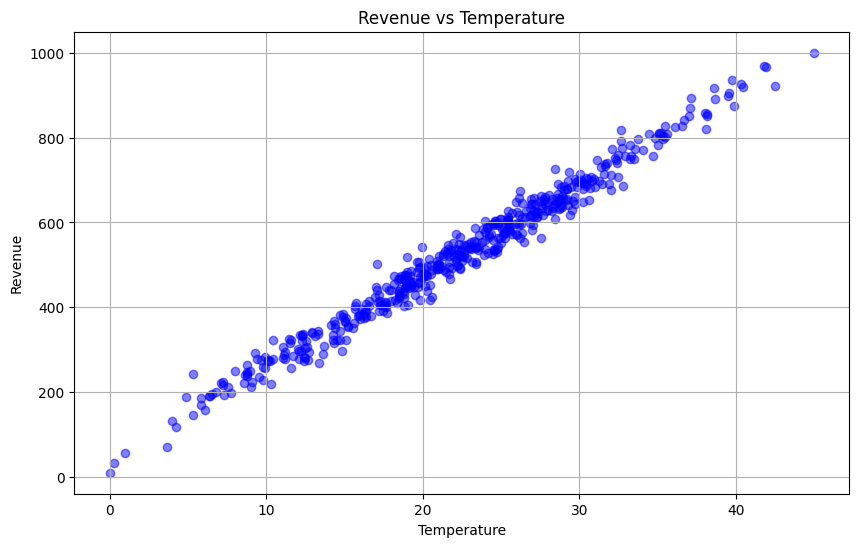

In [64]:
# Caracteristicas del dataset
data_info = {
    "number_of_records": data.shape[0],
    "number_of_features": data.shape[1] - 1,  # Subtracting the target column
    "features": list(data.columns),
}
# Estadísticas descriptivas de cada característica
descriptive_stats = data.describe()

# Información sobre valores faltantes o nulos en el dataset
missing_values = data.isnull().sum()

# Si la columna objetivo es numérica, podemos obtener su rango de valores
# Si es categórica, podemos obtener las clases únicas y su distribución
if pd.api.types.is_numeric_dtype(data[data_info["features"][-1]]):
    target_range = (
        data[data_info["features"][-1]].min(),
        data[data_info["features"][-1]].max(),
    )
    target_info = {"type": "numeric", "range": target_range}
else:
    unique_classes = data[data_info["features"][-1]].unique()
    class_distribution = data[data_info["features"][-1]].value_counts()
    target_info = {
        "type": "categorical",
        "unique_classes": unique_classes,
        "class_distribution": class_distribution,
    }

# Agregando la información adicional al diccionario data_info
data_info["descriptive_stats"] = descriptive_stats
data_info["missing_values"] = missing_values
data_info["target_info"] = target_info

def print_data_info(data_info):
    print("Información del Dataset:\n")
    
    # Imprimir información básica
    print(f"Número de registros: {data_info['number_of_records']}")
    print(f"Número de características: {data_info['number_of_features']}")
    print(f"Características: {', '.join(data_info['features'])}\n")
    
    # Imprimir estadísticas descriptivas
    print("Estadísticas Descriptivas:")
    print(data_info['descriptive_stats'])
    print("\n")
    
    # Imprimir información sobre valores faltantes
    print("Valores Faltantes por Característica:")
    for feature, missing in data_info['missing_values'].items():
        print(f"{feature}: {missing}")
    print("\n")
    
    # Imprimir información de la columna objetivo
    print("Información de la Columna Objetivo:")
    if data_info['target_info']['type'] == 'numeric':
        print(f"Tipo: Numérico")
        print(f"Rango: {data_info['target_info']['range']}")
    else:
        print(f"Tipo: Categórico")
        print(f"Clases Únicas: {', '.join(data_info['target_info']['unique_classes'])}")
        print("Distribución de Clases:")
        for cls, count in data_info['target_info']['class_distribution'].items():
            print(f"{cls}: {count}")
    print("\n")

print_data_info(data_info)

#Graficamos los datos
plt.figure(figsize=(10, 6))
plt.scatter(data['Temperature'], data['Revenue'], color='blue', alpha=0.5)
plt.title('Revenue vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()


## Parte 2: Division de datos

Aqui realizamos la division de datos en subsets o conjuntos, uno de entrenamiento (train), otro de pruebas (test) y otro de validación (val)

In [65]:
# Dividimos en dos el dataset
# Variable Independiente
X = data[["Temperature"]]
# Variable dependiente
y = data["Revenue"]

# División a subsets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Aqui usando la libreria de scikit learn se entrena el modelo de regresión lineal
model = LinearRegression(fit_intercept=False, copy_X=False, positive=True)
model.fit(X_train, y_train)

LinearRegression(copy_X=False, fit_intercept=False, positive=True)

## Parte 3: Desempeño y validación del modelo

Primero sacaremos el rendimiento de este primer modelo, luego calcularemos el sesgo que tenga, la varianza y si comote overfitting, underfitting o ninguno de los dos

### Uso de conjuntos de validación y prueba
Después de entrenar el modelo lineal simple, calculamos métricas de rendimiento en el conjunto de entrenamiento y validación. Estas métricas nos permiten evaluar el desempeño del modelo y determinar si hay problemas de sesgo o varianza. Además, comparamos estas métricas con las del modelo Ridge para decidir cuál modelo es más adecuado.

El conjunto de validación es esencial en este proceso, ya que nos ayuda a evaluar cómo se desempeñaría el modelo en datos no vistos sin tocar el conjunto de prueba.

Finalmente, una vez que se selecciona el modelo final (ya sea el lineal simple o el Ridge), utilizamos el conjunto de prueba para reportar la capacidad de generalización del modelo. Es importante no usar el conjunto de prueba antes de esta etapa final para evitar un sobreajuste al conjunto de prueba.

In [66]:
# Predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)
# Metricas del rendimiento (MSE y R^2)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
val_mse = mean_squared_error(y_val, val_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)
val_r2 = r2_score(y_val, val_predictions)

# Guardamos las metricas como dataframe
metrics_df = pd.DataFrame(
    {
        "Metricas": [
            "MSE (train)",
            "R^2 (train)",
            "MSE (test)",
            "R^2 (test)",
            "MSE (val)",
            "R^2 (val)",
        ],
        "Valores": [train_mse, train_r2, test_mse, test_r2, val_mse, val_r2],
    }
)
# Mostramos las metricas generadas
metrics_df

,Metricas,Valores
0,MSE (train),868.753196
1,R^2 (train),0.973563
2,MSE (test),1028.919039
3,R^2 (test),0.959984
4,MSE (val),654.920060
5,R^2 (val),0.977014


### Determinación del sesgo, varianza y nivel de ajuste

Para determinar el sesgo y la varianza de nuestro modelo, utilizamos el coeficiente de determinación \( $R^2$ \). Las elecciones de los umbrales para determinar el sesgo y la varianza se basan en lo siguiente:

1. **Sesgo (Bias)**:
    - Se considera que hay un sesgo alto si \( $R^2$ \) es significativamente bajo (menor que 0.7) para el conjunto de entrenamiento y validación, lo que indica que el modelo no se ajusta bien a los datos.
    - Se considera que hay un sesgo bajo si \( $R^2$ \) es alto (mayor que 0.9) para ambos conjuntos, indicando un buen ajuste del modelo a los datos.
    - En otros casos, se considera que el sesgo es medio.

2. **Varianza**:
    - Se considera que hay una alta varianza si \( $R^2$ \) es alto para el conjunto de entrenamiento pero bajo para el conjunto de validación, o si la diferencia entre ellos es mayor que 0.2. Esto indica que el modelo puede estar sobreajustando a los datos de entrenamiento.
    - Se considera que la varianza es baja si \( $R^2$ \) es alto para ambos conjuntos, lo que indica que el modelo generaliza bien.
    - En otros casos, la varianza se considera media.

Los criterios anteriores ayudan a diagnosticar problemas de underfitting (alto sesgo y baja varianza) y overfitting (bajo sesgo y alta varianza).

In [67]:
# Funcion para determinar el sesgo
def determinar_sesgo(train_r2, val_r2):
    if train_r2 < 0.7 and val_r2 < 0.7:
        return "alto"
    elif train_r2 > 0.9 and val_r2 > 0.9:
        return "bajo"
    else:
        return "medio"

# Funcion para determinar el grado de varianza
def determinar_varianza(train_r2, val_r2):
    if train_r2 > 0.9 and (val_r2 < 0.7 or abs(train_r2 - val_r2) > 0.2):
        return "alto"
    elif train_r2 > 0.9 and val_r2 > 0.9:
        return "bajo"
    else:
        return "medio"

#Funcion para determinar el nivel de ajuste, o sea overfitting, underfitting o ninguno
def determinar_ajuste(bias, variance):
    if bias == "alto" and variance == "bajo":
        return "underfitting"
    elif bias == "bajo" and variance == "alto":
        return "overfitting"
    elif bias == "bajo" and variance == "bajo":
        return "ajuste adecuado"
    else:
        return "caso atipico"

# Funcion para hacer el diagnostico
def diagnostico(train_r2, val_r2):
    sesgo = determinar_sesgo(train_r2, val_r2)
    varianza = determinar_varianza(train_r2, val_r2)
    ajuste = determinar_ajuste(sesgo, varianza)
    
    # Crear un DataFrame con una fila para el diagnóstico
    data = {
        "Nivel de sesgo": [sesgo],
        "Nivel de varianza": [varianza],
        "Nivel de ajuste": [ajuste]
    }
    
    df_diagnostico = pd.DataFrame(data)
    return df_diagnostico

#Realizamos el diagnostico
diagnostico(train_r2, val_r2)

,Nivel de sesgo,Nivel de varianza,Nivel de ajuste
0,bajo,bajo,ajuste adecuado


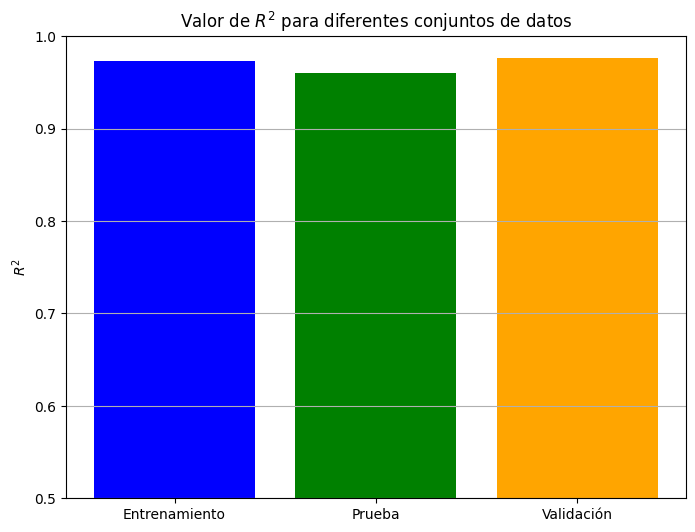

In [78]:
# Graficamos para poder observar de mejor forma
train_r2_real = metrics_df.loc[
    metrics_df["Metricas"] == "R^2 (train)", "Valores"
].values[0]
test_r2_real = metrics_df.loc[metrics_df["Metricas"] == "R^2 (test)", "Valores"].values[
    0
]
val_r2_real = metrics_df.loc[metrics_df["Metricas"] == "R^2 (val)", "Valores"].values[0]
labels = ["Entrenamiento", "Prueba", "Validación"]
r2_values_real = [train_r2_real, test_r2_real, val_r2_real]
plt.figure(figsize=(8, 6))
plt.bar(labels, r2_values_real, color=["blue", "green", "orange"])
plt.ylabel("$R^2$")
plt.title("Valor de $R^2$ para diferentes conjuntos de datos")
plt.ylim(0.5, 1)
plt.grid(axis="y")
plt.show()

Como se puede observar en los resultados el modelo actual ya se ajusta de manera adecuada a los datos, en donde no se observan que haya un sesgo importante, en donde el grado de variabilidad es bajo y no hay un overfitting o underfitting con el modelo actual, sin aplicar regularización

## Parte 4: Tecnicas de regularizacion

Aqui intentaremos regularizar para ver si hay mejoras respecto al modelo de regresión lineal, usaremos la regresión de cresta (Ridge) para este caso en particular.
La regularización Ridge agrega un término de penalización al error del modelo para evitar que los coeficientes se vuelvan demasiado grandes, lo que puede ayudar a prevenir el overfitting, no obstante no hay ningun tipo de overfitting observado en el modelo de regresión, sin embargo se implementara de todas formas para poder ver como mejora le modelo, como se habia comentado anteriormente.

In [68]:
# Definición del modelo Ridge y búsqueda de cuadrícula para el parámetro de regularización alpha
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 50, 100]}
ridge_regressor = GridSearchCV(Ridge(), parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, y_train)

# Mejor parámetro y MSE
best_alpha = ridge_regressor.best_params_['alpha']
best_mse = ridge_regressor.best_score_

print("Mejor Alpha: ", best_alpha)
print("Mejor MSE: ", best_mse)

Mejor Alpha:  1e-15
Mejor MSE:  -633.052087263211


In [69]:
# Predicciones con el modelo Ridge
ridge_train_predictions = ridge_regressor.predict(X_train)
ridge_test_predictions = ridge_regressor.predict(X_test)
ridge_val_predictions = ridge_regressor.predict(X_val)

# Métricas del rendimiento (MSE y R^2) para el modelo Ridge
ridge_train_mse = mean_squared_error(y_train, ridge_train_predictions)
ridge_test_mse = mean_squared_error(y_test, ridge_test_predictions)
ridge_val_mse = mean_squared_error(y_val, ridge_val_predictions)

ridge_train_r2 = r2_score(y_train, ridge_train_predictions)
ridge_test_r2 = r2_score(y_test, ridge_test_predictions)
ridge_val_r2 = r2_score(y_val, ridge_val_predictions)

ridge_metrics_df = pd.DataFrame(
    {
        "Metricas": [
            "MSE (train) Ridge",
            "R^2 (train) Ridge",
            "MSE (test) Ridge",
            "R^2 (test) Ridge",
            "MSE (val) Ridge",
            "R^2 (val) Ridge",
        ],
        "Valores": [ridge_train_mse, ridge_train_r2, ridge_test_mse, ridge_test_r2, ridge_val_mse, ridge_val_r2],
    }
)

ridge_metrics_df

,Metricas,Valores
0,MSE (train) Ridge,626.363148
1,R^2 (train) Ridge,0.980939
2,MSE (test) Ridge,711.898211
3,R^2 (test) Ridge,0.972313
4,MSE (val) Ridge,525.210236
5,R^2 (val) Ridge,0.981566


## Comparaciones

      Modelo 1                        Modelo 2            
      Metricas      Valores           Metricas     Valores
0  MSE (train)   868.753196  MSE (train) Ridge  626.363148
1  R^2 (train)     0.973563  R^2 (train) Ridge    0.980939
2   MSE (test)  1028.919039   MSE (test) Ridge  711.898211
3   R^2 (test)     0.959984   R^2 (test) Ridge    0.972313
4    MSE (val)   654.920060    MSE (val) Ridge  525.210236
5    R^2 (val)     0.977014    R^2 (val) Ridge    0.981566


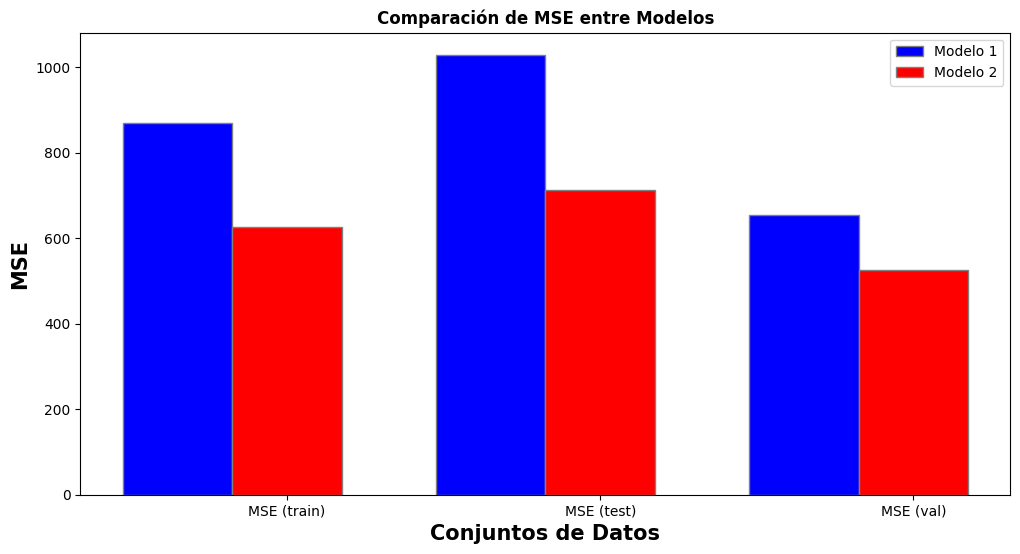

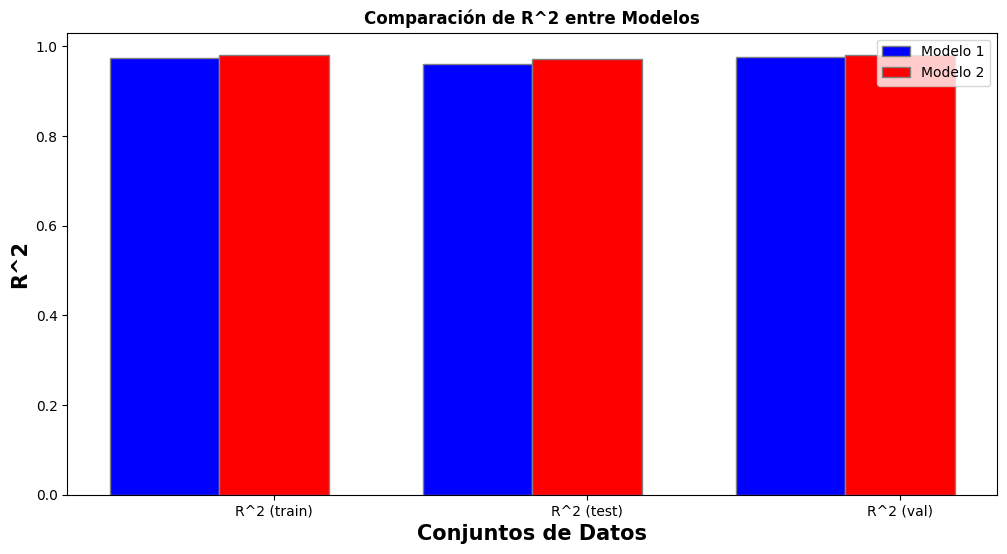

In [70]:
combined_metrics = pd.concat(
    [metrics_df, ridge_metrics_df], axis=1, keys=["Modelo 1", "Modelo 2"]
)
print(combined_metrics)
bar_width = 0.35
# Comparacion con grafica de barras (MSE)
mse_labels = ["MSE (train)", "MSE (test)", "MSE (val)"]
model_1_mse_values = [
    combined_metrics["Modelo 1"]["Valores"][i] for i in range(0, 6, 2)
]
model_2_mse_values = [
    combined_metrics["Modelo 2"]["Valores"][i] for i in range(0, 6, 2)
]
plt.figure(figsize=(12, 6))
r1 = np.arange(len(model_1_mse_values))
r2 = [x + bar_width for x in r1]
plt.bar(
    r1,
    model_1_mse_values,
    width=bar_width,
    color="blue",
    edgecolor="grey",
    label="Modelo 1",
)
plt.bar(
    r2,
    model_2_mse_values,
    width=bar_width,
    color="red",
    edgecolor="grey",
    label="Modelo 2",
)
plt.title("Comparación de MSE entre Modelos", fontweight="bold")
plt.xlabel("Conjuntos de Datos", fontweight="bold", fontsize=15)
plt.ylabel("MSE", fontweight="bold", fontsize=15)
plt.xticks([r + bar_width for r in range(len(model_1_mse_values))], mse_labels)
plt.legend()
plt.show()
# Comparación con grafica de barras (R^2)r2_labels = ["R^2 (train)", "R^2 (test)", "R^2 (val)"]
model_1_r2_values = [combined_metrics["Modelo 1"]["Valores"][i] for i in range(1, 6, 2)]
model_2_r2_values = [combined_metrics["Modelo 2"]["Valores"][i] for i in range(1, 6, 2)]
plt.figure(figsize=(12, 6))
r1 = np.arange(len(model_1_r2_values))
r2 = [x + bar_width for x in r1]
plt.bar(
    r1,
    model_1_r2_values,
    width=bar_width,
    color="blue",
    edgecolor="grey",
    label="Modelo 1",
)
plt.bar(
    r2,
    model_2_r2_values,
    width=bar_width,
    color="red",
    edgecolor="grey",
    label="Modelo 2",
)
plt.title("Comparación de R^2 entre Modelos", fontweight="bold")
plt.xlabel("Conjuntos de Datos", fontweight="bold", fontsize=15)
plt.ylabel("R^2", fontweight="bold", fontsize=15)
r2_labels = ["R^2 (train)", "R^2 (test)", "R^2 (val)"]
plt.xticks([r + bar_width for r in range(len(model_1_r2_values))], r2_labels)
plt.legend()
plt.show()

Los resultados muestran que pese a que hay mejoras dentro de lo que seria el segundo modelo (Ridge), el primero al no mostrar problemas de ajuste, de sesgo o de varianza, hacen que estas mejoras no sean muy dramaticas, o sea que sean muy pequeñas con respecto al primer modelo, no obstante es importante denotar que en casos de que los analisis muestren un problema con el ajuste como un overfittng, el segundo modelo podria ser mejor opción para manejar este tipo de situaciones y tener un mejor rendimiento en la modelación de datos

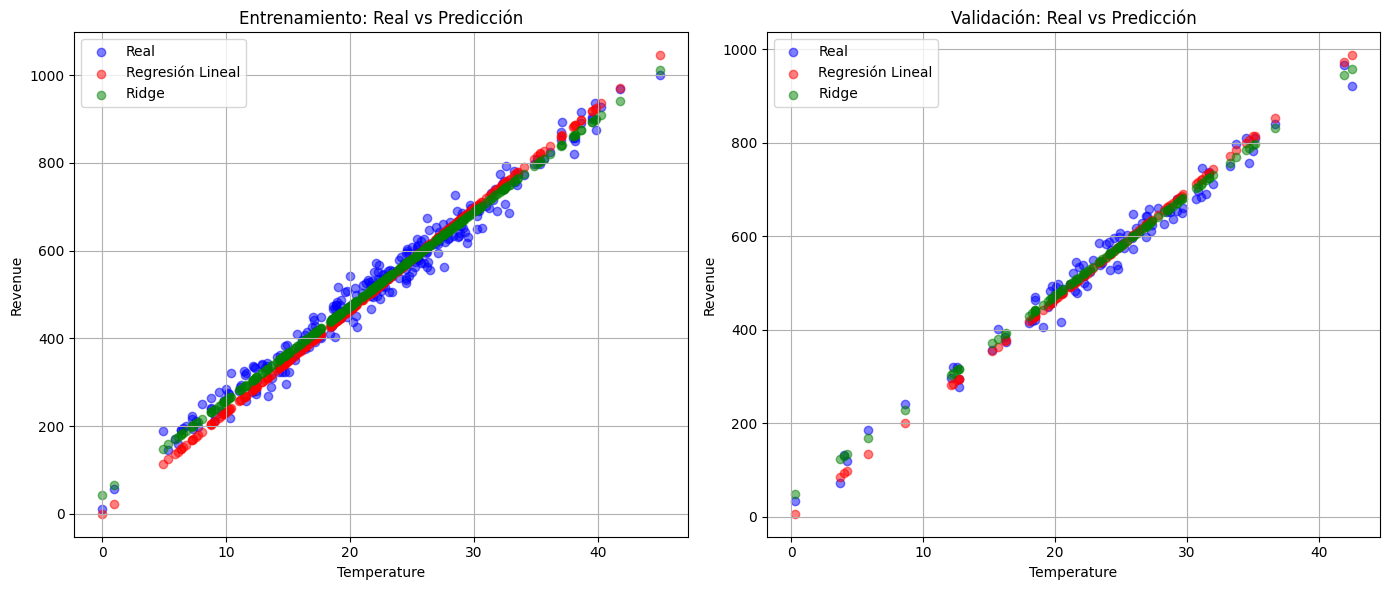

In [71]:
## Comparacion en graficoç
plt.figure(figsize=(14, 6))

# Datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Real')
plt.scatter(X_train, train_predictions, color='red', alpha=0.5, label='Regresión Lineal')
plt.scatter(X_train, ridge_train_predictions, color='green', alpha=0.5, label='Ridge')
plt.title('Entrenamiento: Real vs Predicción')
plt.xlabel('Temperature')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)

# Datos de validacion
plt.subplot(1, 2, 2)
plt.scatter(X_val, y_val, color='blue', alpha=0.5, label='Real')
plt.scatter(X_val, val_predictions, color='red', alpha=0.5, label='Regresión Lineal')
plt.scatter(X_val, ridge_val_predictions, color='green', alpha=0.5, label='Ridge')
plt.title('Validación: Real vs Predicción')
plt.xlabel('Temperature')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)

plt.tight_layout()

Estas graficas confirman que el modelo de Ridge no suponen una gran mejoria en comparación con el modelo de regresión lineal que se hizo previamente y se ajustan bien a los datos que tenemos

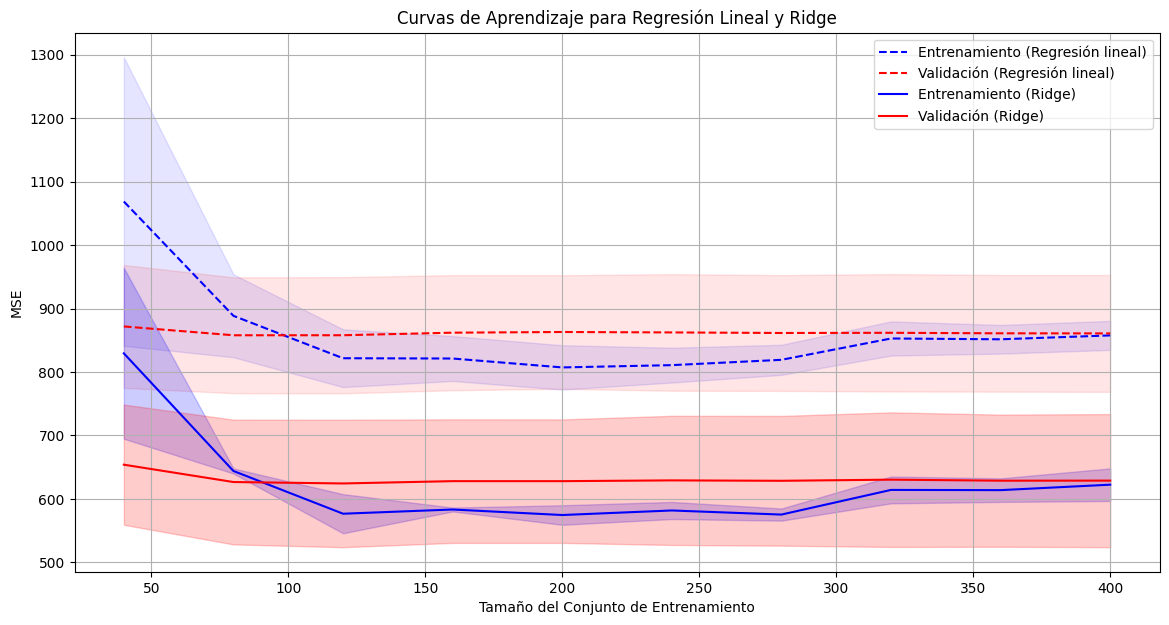

In [72]:
# Learning curves (Curvas de aprendizaje) para ambos modelos
# Regresion lineal
train_sizes_lin, train_scores_lin, val_scores_lin = learning_curve(
    LinearRegression(fit_intercept=False, copy_X=False, positive=True),
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=5,
    scoring='neg_mean_squared_error'
)

# Regresion Ridge
train_sizes_ridge, train_scores_ridge, val_scores_ridge = learning_curve(
    Ridge(alpha=best_alpha),
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=5,
    scoring='neg_mean_squared_error'
)

# Calculamos promedio y desviación estandar para el subconjunto de prueba y validacion para ambos modelos

# Regresion lineal
train_mean_lin = -np.mean(train_scores_lin, axis=1)
train_std_lin = np.std(train_scores_lin, axis=1)
val_mean_lin = -np.mean(val_scores_lin, axis=1)
val_std_lin = np.std(val_scores_lin, axis=1)

# Regresion Ridge
train_mean_ridge = -np.mean(train_scores_ridge, axis=1)
train_std_ridge = np.std(train_scores_ridge, axis=1)
val_mean_ridge = -np.mean(val_scores_ridge, axis=1)
val_std_ridge = np.std(val_scores_ridge, axis=1)

# Graficamos y observamos el resultado

plt.figure(figsize=(14, 7))

# Regresion lineal
plt.plot(train_sizes_lin, train_mean_lin, '--', label='Entrenamiento (Regresión lineal)', color='blue')
plt.fill_between(train_sizes_lin, train_mean_lin - train_std_lin, train_mean_lin + train_std_lin, color='blue', alpha=0.1)
plt.plot(train_sizes_lin, val_mean_lin, '--', label='Validación (Regresión lineal)', color='red')
plt.fill_between(train_sizes_lin, val_mean_lin - val_std_lin, val_mean_lin + val_std_lin, color='red', alpha=0.1)

# Regresion Ridge
plt.plot(train_sizes_ridge, train_mean_ridge, label='Entrenamiento (Ridge)', color='blue')
plt.fill_between(train_sizes_ridge, train_mean_ridge - train_std_ridge, train_mean_ridge + train_std_ridge, color='blue', alpha=0.2)
plt.plot(train_sizes_ridge, val_mean_ridge, label='Validación (Ridge)', color='red')
plt.fill_between(train_sizes_ridge, val_mean_ridge - val_std_ridge, val_mean_ridge + val_std_ridge, color='red', alpha=0.2)

plt.title('Curvas de Aprendizaje para Regresión Lineal y Ridge')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

Los modelos muestran patrones similares a la hora de observar sus curvas de aprendizaje, ademas vemos que conforme aumenta el tamaño de train, el MSE de train aumenta mientras que el MSE de val disminuye, esto en general demuestra que ambos modelos tienen un aprendizaje similar

En conclusión podemos decir que en este caso y en base a las evaluaciones anteriores, no hay un gran impacto entre un modelo lineal y uno regularizado,. asi que en este caso en particular y en casos en donde se presenten condiciones similares, no es necesario aplicar regularización al modelo, eso solo se debe de reservar en caso de que un modelo presente por ejemplo un overfitting